[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/strumke/AIMS_XAI_Inga/blob/main/interpretations.ipynb)

In [16]:
from IPython.display import clear_output
import time

# Homework - 1

## Local, Global, Model-Agnostic, Model-Specific

- An explaination is any piece of information derived about a model that helps understand why the model made particular predictions or how the model works. An explaination aims to make the decision-making process of the model transparent and interpreteable.

- Local Explainations: These set of explainatiosn describes why a model made a specific prediction for a sinlge instsance or sample point.

- Global Explainations: These set of explainations describe the overall behavior of the model across all possible inputs showing how the model generally makes decisions.

- Model-Agnostic Explainations: These are explainations that work with any machine learning model treating it as a black box and needing access to just the inputs and outputs; they do not assess the model's internal structure.

- Model-Specific Explainations: these are methdos of explaination designed for partocular model architectures taking advantage of the architecure or model internal structure. These explaination models only work for the specific mode architecture type they were designed for.

In [2]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss

## Train XGBoost Model On XGBoost data


Test Accuracy: 0.8112

Confusion Matrix:

Model training complete!


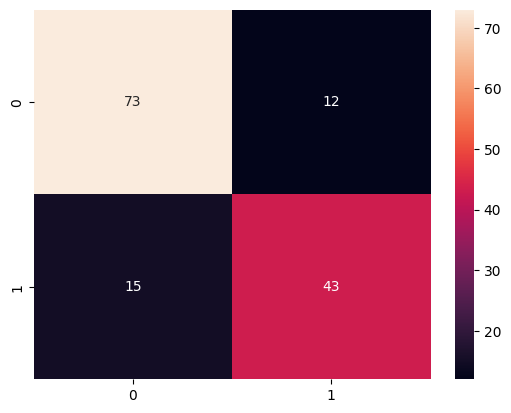

In [17]:
# Import necessary libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# Load Titanic dataset
url = "../data/titanic_data.csv"
df = pd.read_csv(url)

df_processed = df.copy()      # --> Deal with missing values
df_processed['age'].fillna(df_processed['age'].median(), inplace=True)
df_processed['fare'].fillna(df_processed['fare'].median(), inplace=True)

df_processed.drop(['name'], axis=1, inplace=True)     # -- > Drop non-relevant columns

df_processed['sex'] = df_processed['sex'].map({'male': 0, 'female': 1})     # --> Encode categorical features

X = df_processed.drop('survived', axis=1)      # --> Define inputs and targets
y = df_processed['survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)   # --> train and test split
print("-----------------------------------------------------------")
print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

print("-----------------------------------------------------------")
print("\nTraining XGBoost model...")
model = xgb.XGBClassifier(      # --> Train XGBoost Model
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

clear_output()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

model.save_model('homework1_xgboost_model.json')      # --> Save XGBoost model
print("\nModel training complete!")

## Logistic Regression Surrogate Model

------------------------------------------------
XGBoost Model Performance

Original model (XGBoost) training accuracy: 0.9299
Original model (XGBoost) test accuracy: 0.8112
------------------------------------------------
Train Logistic Regression Surrogate Model

Logistic Regression Surrogate - Training Fidelity: 0.8669
Logistic Regression Surrogate - Test Fidelity: 0.8951
Logistic Regression Surrogate - Actual Test Accuracy: 0.8182

Confusion Matrix (Surrogate vs Original Model on Test Set):
[[80  8]
 [ 7 48]]
------------------------------------------------
Logistic Regression Model Explainations


Text(0.5, 1.0, 'Surrogate Logistic Regression Coefficients')

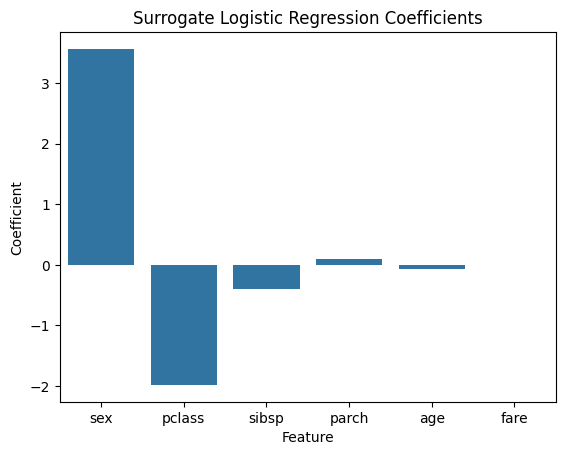

In [ ]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

print("------------------------------------------------")
print("XGBoost Model Performance")
y_train_pred = model.predict(X_train)      # Get train and test predictions from XGBoost model
y_test_pred = model.predict(X_test)
print(f"\nOriginal model (XGBoost) training accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Original model (XGBoost) test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

print("------------------------------------------------")
print("Train Logistic Regression Surrogate Model")
lr_surrogate = LogisticRegression(max_iter=1000, random_state=42)       # --> Train LogReg(X) -> XGBoost(X)
lr_surrogate.fit(X_train, y_train_pred)

y_train_lr_pred = lr_surrogate.predict(X_train)     # --> Evaluate LogReg Surrogate Model
y_test_lr_pred = lr_surrogate.predict(X_test)
lr_train_acc = accuracy_score(y_train_pred, y_train_lr_pred)
lr_test_acc = accuracy_score(y_test_pred, y_test_lr_pred)
print(f"\nLogistic Regression Surrogate - Training Fidelity: {lr_train_acc:.4f}")
print(f"Logistic Regression Surrogate - Test Fidelity: {lr_test_acc:.4f}")
print(f"Logistic Regression Surrogate - Actual Test Accuracy: {accuracy_score(y_test, y_test_lr_pred):.4f}")

print("\nConfusion Matrix (Surrogate vs Original Model on Test Set):")
print(confusion_matrix(y_test_pred, y_test_lr_pred))

print("------------------------------------------------")
print("Logistic Regression Model Explainations")
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_surrogate.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)
sns.barplot(coef_df, x="Feature", y="Coefficient")
plt.title("Surrogate Logistic Regression Coefficients")

## DecisionTree Surrogate Model

------------------------------------------------
XGBoost Model Performance

Original model (XGBoost) training accuracy: 0.9299
Original model (XGBoost) test accuracy: 0.8112
------------------------------------------------
Train Decision Tree Surrogate Model

Decision Tree Surrogate - Training Fidelity: 0.8949
Decision Tree Surrogate - Test Fidelity: 0.8531
Decision Tree Surrogate - Actual Test Accuracy: 0.7902

Confusion Matrix (Surrogate vs Original Model on Test Set):
[[81  7]
 [14 41]]
------------------------------------------------
Train Decision Tree Surrogate Model

Decision Tree Feature Importance:


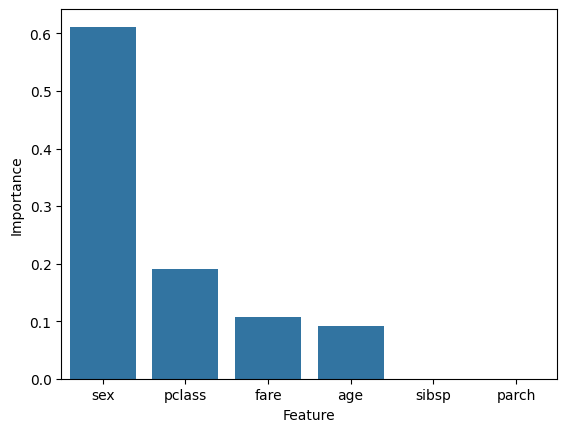

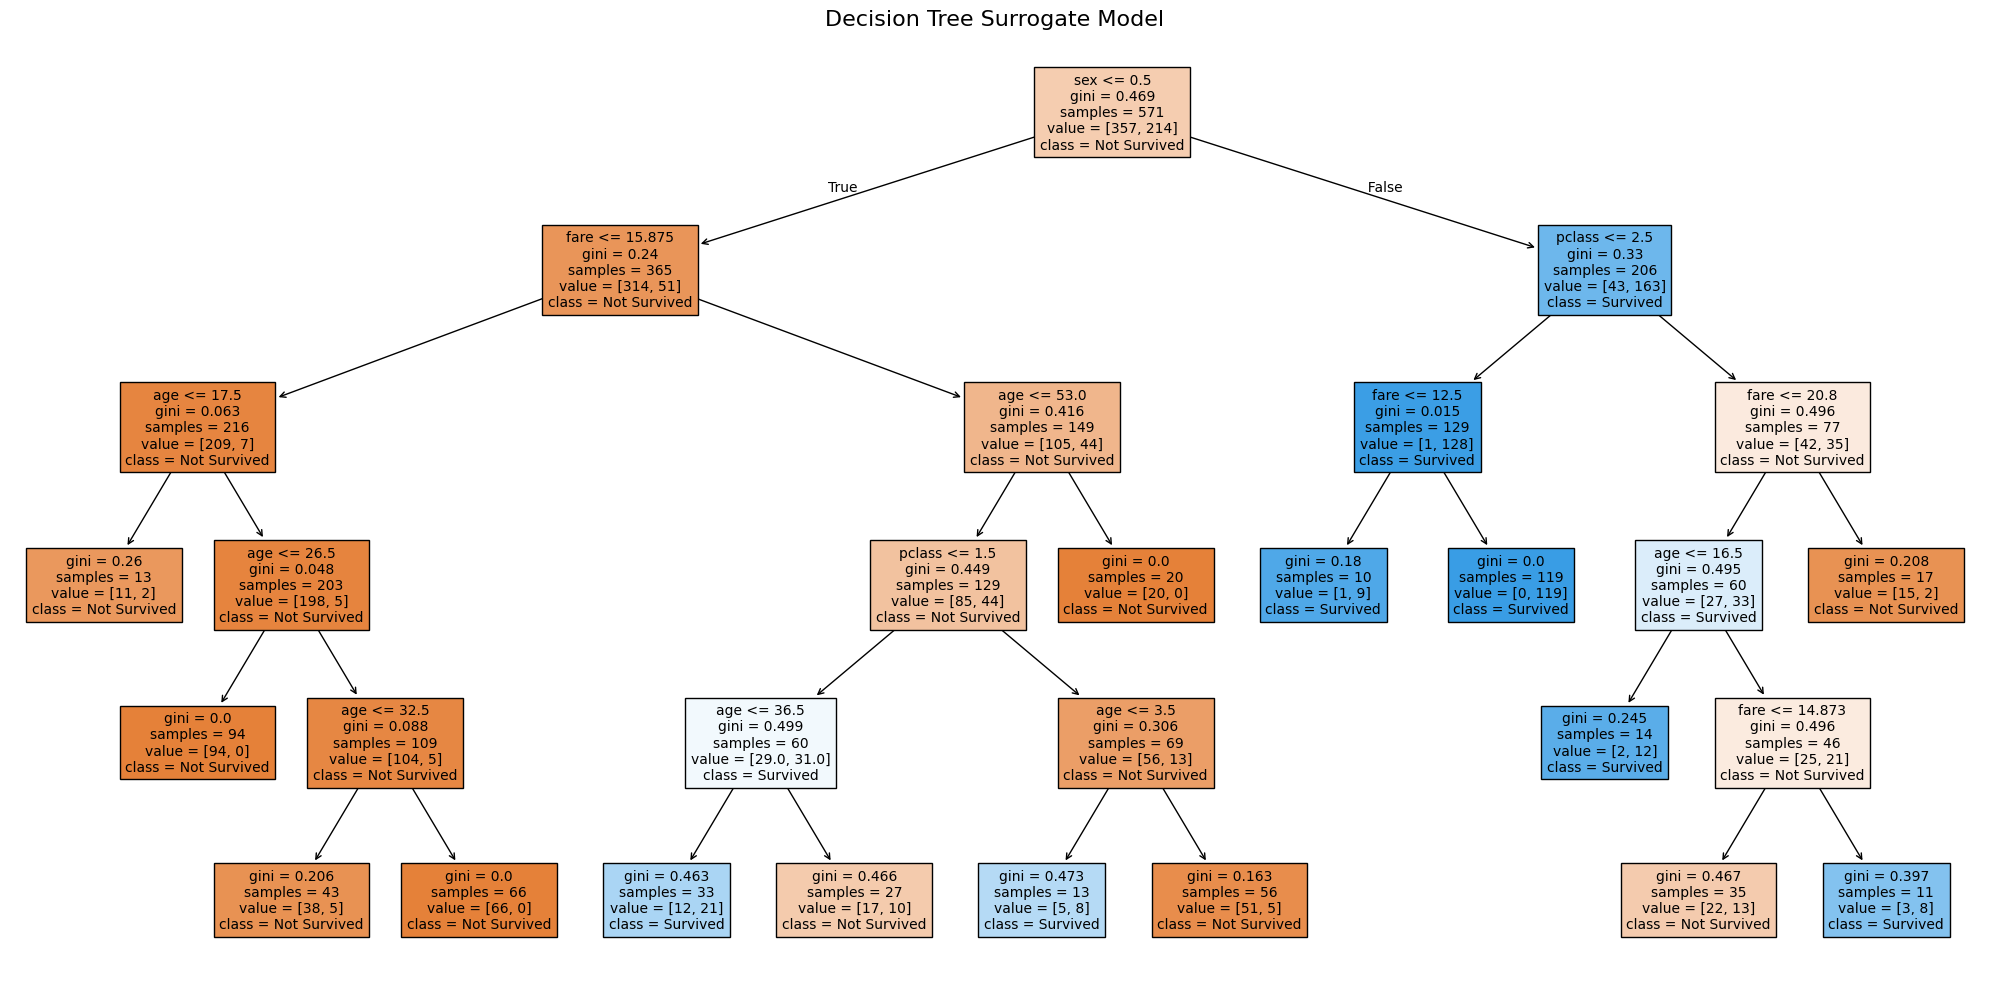

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

print("------------------------------------------------")
print("XGBoost Model Performance")
y_train_pred = model.predict(X_train)      # Get train and test predictions from XGBoost model
y_test_pred = model.predict(X_test)
print(f"\nOriginal model (XGBoost) training accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Original model (XGBoost) test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

print("------------------------------------------------")
print("Train Decision Tree Surrogate Model")
dt_surrogate = DecisionTreeClassifier(      # --> Train LogReg(X) -> XGBoost(X)
    max_depth=5,        # Higer depth was too difficult to interpret !!!
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
dt_surrogate.fit(X_train, y_train_pred)

y_train_dt_pred = dt_surrogate.predict(X_train)
y_test_dt_pred = dt_surrogate.predict(X_test)
dt_train_acc = accuracy_score(y_train_pred, y_train_dt_pred)
dt_test_acc = accuracy_score(y_test_pred, y_test_dt_pred)
print(f"\nDecision Tree Surrogate - Training Fidelity: {dt_train_acc:.4f}")
print(f"Decision Tree Surrogate - Test Fidelity: {dt_test_acc:.4f}")
print(f"Decision Tree Surrogate - Actual Test Accuracy: {accuracy_score(y_test, y_test_dt_pred):.4f}")

print("\nConfusion Matrix (Surrogate vs Original Model on Test Set):")
print(confusion_matrix(y_test_pred, y_test_dt_pred))

print("------------------------------------------------")
print("Train Decision Tree Surrogate Model")
print("\nDecision Tree Feature Importance:")
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_surrogate.feature_importances_
}).sort_values('Importance', ascending=False)
sns.barplot(importance_df, x="Feature", y="Importance")
# print(importance_df)

plt.figure(figsize=(20, 10))
tree.plot_tree(
    dt_surrogate,
    feature_names=X_train.columns,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    fontsize=10
)
plt.title("Decision Tree Surrogate Model", fontsize=16)
plt.tight_layout()
plt.show()

## Compare Surrogate Models

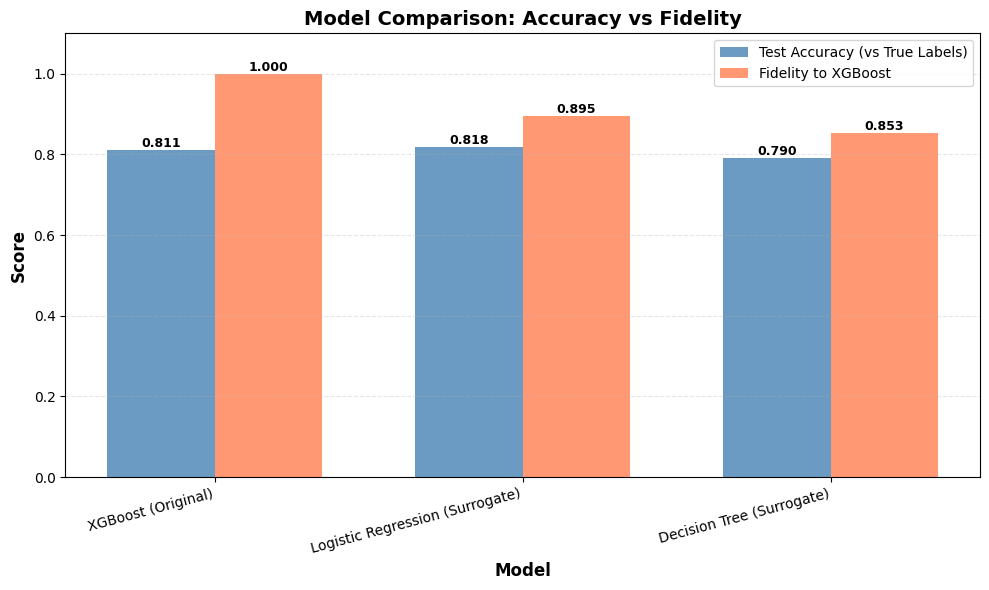

In [32]:
comparison_df = pd.DataFrame({
    'Model': ['XGBoost (Original)', 'Logistic Regression (Surrogate)', 'Decision Tree (Surrogate)'],
    'Test Accuracy (vs True Labels)': [
        accuracy_score(y_test, y_test_pred),
        accuracy_score(y_test, y_test_lr_pred),
        accuracy_score(y_test, y_test_dt_pred)
    ],
    'Fidelity to XGBoost': [
        1.0,  # XGBoost perfectly matches itself
        lr_test_acc,
        dt_test_acc
    ]
})

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Test Accuracy (vs True Labels)'], 
               width, label='Test Accuracy (vs True Labels)', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Fidelity to XGBoost'], 
               width, label='Fidelity to XGBoost', color='coral', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison: Accuracy vs Fidelity', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend(fontsize=10)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


## Local Explaination of Prediction of $f$

-------------------------------------------------
Explain decision for sample point
1. IF sex (0.00) <= 0.50
2. IF fare (76.73) > 15.88
3. IF age (27.00) <= 53.00
4. IF pclass (1.00) <= 1.50
5. IF age (27.00) <= 36.50
THEN Prediction: Survived
---------------------------------------------------------
Highlight features used in decision


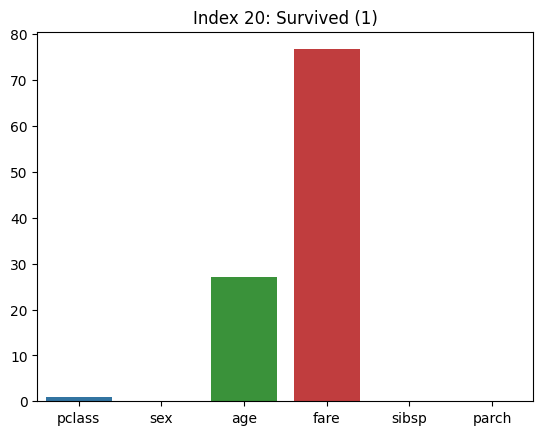

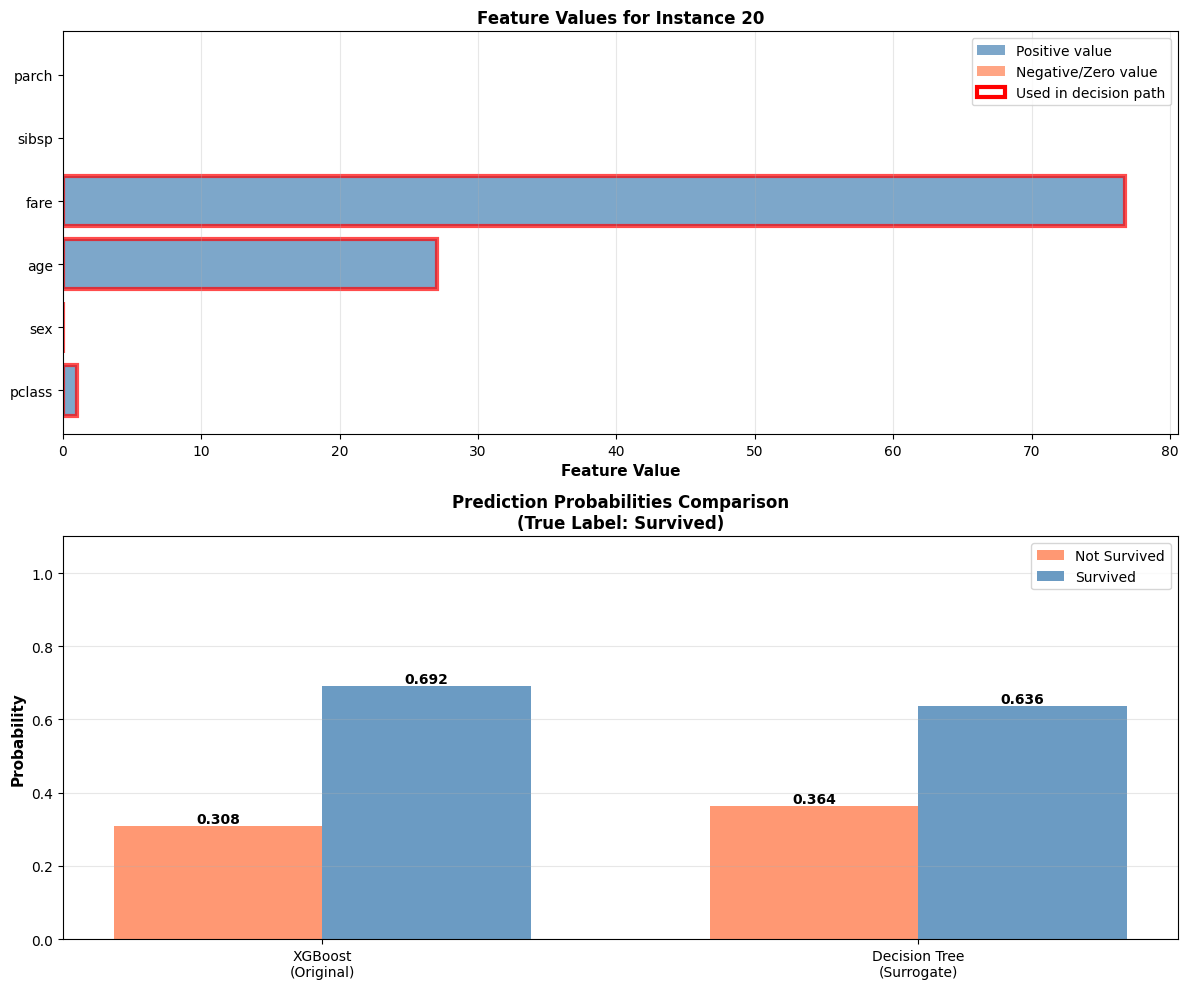

---------------------------------------------------------
SUMMARY
The passenger survived because they were male,
paid a high fare (£76.73), and were aged 27.
The surrogate model agrees with the
original XGBoost model for this instance.


In [51]:
instance_idx = 20       # --> Get the features of a sinlge instance or sample point
instance = X_test.iloc[instance_idx:instance_idx+1]
true_label = y_test.iloc[instance_idx]

sns.barplot(instance)
plt.title(f"Index {instance_idx}: {'Survived' if true_label == 1 else 'Died'} ({true_label})")

print("-------------------------------------------------")
print("Explain decision for sample point")
xgb_pred = model.predict(instance)[0]
xgb_pred_proba = model.predict_proba(instance)[0]
dt_pred = dt_surrogate.predict(instance)[0]
dt_pred_proba = dt_surrogate.predict_proba(instance)[0]

decision_path = dt_surrogate.decision_path(instance)        # --> Get decision path and extract rules for prediction
leaf_id = dt_surrogate.apply(instance)[0]

feature = dt_surrogate.tree_.feature
threshold = dt_surrogate.tree_.threshold
node_indicator = decision_path.toarray()[0]

path_nodes = np.where(node_indicator == 1)[0]
rules = []
for i, node_id in enumerate(path_nodes[:-1]):  # --> Exclude the leaf node
    if instance.iloc[0, feature[node_id]] <= threshold[node_id]:
        direction = "<="
        next_node = dt_surrogate.tree_.children_left[node_id]
    else:
        direction = ">"
        next_node = dt_surrogate.tree_.children_right[node_id]
    
    feature_name = X_train.columns[feature[node_id]]
    feature_value = instance.iloc[0, feature[node_id]]
    threshold_value = threshold[node_id]
    
    rule = f"{i+1}. IF {feature_name} ({feature_value:.2f}) {direction} {threshold_value:.2f}"
    rules.append(rule)
    print(rule)

leaf_value = dt_surrogate.tree_.value[leaf_id][0]       # --> Get leaf node prediction
leaf_samples = dt_surrogate.tree_.n_node_samples[leaf_id]
print(f"THEN Prediction: {'Survived' if dt_pred == 1 else 'Not Survived'}")

print("---------------------------------------------------------")
print("Highlight features used in decision")
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
ax1 = axes[0]
feature_values = instance.iloc[0].values
colors = ['steelblue' if val > 0 else 'coral' for val in feature_values]
bars = ax1.barh(X_train.columns, feature_values, color=colors, alpha=0.7)
ax1.set_xlabel('Feature Value', fontsize=11, fontweight='bold')
ax1.set_title(f'Feature Values for Instance {instance_idx}', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Highlight features used in decision path
features_in_path = [X_train.columns[feature[node]] for node in path_nodes[:-1]]
for i, feat in enumerate(X_train.columns):
    if feat in features_in_path:
        bars[i].set_edgecolor('red')
        bars[i].set_linewidth(3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, label='Positive value'),
    Patch(facecolor='coral', alpha=0.7, label='Negative/Zero value'),
    Patch(facecolor='white', edgecolor='red', linewidth=3, label='Used in decision path')
]
ax1.legend(handles=legend_elements, loc='best')


ax2 = axes[1]       # --> Compare decision probabilities
models = ['XGBoost\n(Original)', 'Decision Tree\n(Surrogate)']
not_survived_probs = [xgb_pred_proba[0], dt_pred_proba[0]]
survived_probs = [xgb_pred_proba[1], dt_pred_proba[1]]

x_pos = np.arange(len(models))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, not_survived_probs, width, 
                label='Not Survived', color='coral', alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, survived_probs, width, 
                label='Survived', color='steelblue', alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('Probability', fontsize=11, fontweight='bold')
ax2.set_title(f'Prediction Probabilities Comparison\n(True Label: {"Survived" if true_label == 1 else "Not Survived"})', 
              fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models)
ax2.legend(fontsize=10)
ax2.set_ylim([0, 1.1])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("---------------------------------------------------------")
print("SUMMARY")

instance_values = instance.iloc[0]
sex_str = "male" if instance_values['sex'] == 0 else "female"
fare_val = instance_values['fare']
age_val = instance_values['age']

print(f"The passenger {'survived' if dt_pred == 1 else 'did not survive'} because they were {sex_str},")
print(f"paid a {'low' if fare_val < 30 else 'high'} fare (£{fare_val:.2f}), and were aged {age_val:.0f}.")
print(f"The surrogate model {'agrees' if xgb_pred == dt_pred else 'DISAGREES'} with the")
print(f"original XGBoost model for this instance.")